In [17]:
import pandas as pd
import numpy as np

# utility
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.class_weight import compute_class_weight

#viz
import seaborn as sns
import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# parallel
import ray

try:
    ray.shutdown()
except:
    print("ray not started")

ray.init()

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, LeaveOneOut, KFold
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA, NMF
# from mlxtend.feature_selection import SequentialFeatureSelector
# from tensorflow.keras.callbacks import EarlyStopping

# models
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

# analysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None) # show all cols

# from data_cleaning import clean_raw_data, create_dataset, get_all_results

from data_cleaning import clean_raw_data, create_dataset
from sklearn.ensemble import ExtraTreesClassifier
from mango import Tuner

RESULTS_DIR = "results/"
DATA_DIR = "data/"
SEED = 42

# reload modules in py files
%load_ext autoreload
%autoreload 2

2023-04-03 14:15:47,151	INFO worker.py:1553 -- Started a local Ray instance.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TODO 4
Very low on the list of priorities but I had some dependency issues as I was just installing things via pip which doesn't check package dependencies. requirements.txt should work if you install all the packages using that, but could be of interest eventually to use something like poem or pipenv that to actually sort out dependencies the right way. But for now thats research...

### install any packages here 

In [ ]:
!pip install xgboost

     |████████████████████████████████| 12.3 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 98.1 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3


In [78]:
!pip uninstall --yes mlxtend

Found existing installation: mlxtend 0.22.0
Uninstalling mlxtend-0.22.0:
  Successfully uninstalled mlxtend-0.22.0


## clean dataset using functions in src/data_cleaning.py

In [18]:


X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
print("No missing values in X: ", (X.isna().sum() == 0).all())
print("No missing values in y: ", (y.isna().sum() == 0).all())
print(X.columns)
display(X.head(5),X.shape ,y.head(5), y.shape)


/home/mmoschit/Concussions-and-Athletic-Performance/src
No missing values in X:  True
No missing values in y:  True
Index(['age', 'concussions', 'weight', 'bimanualscore_washer', 'RT_V', 'RT_HR',
       'Delta_RT', 'MT_V', 'MT_HR', 'Delta_MT', 'TMT_V', 'TMT_HR', 'CMT_V',
       'CMT_HR', 'cvRT_V', 'cvRT_HR', 'stdRT_V', 'stdRT_HR', 'BallPath_V',
       'BallPath_HR', 'FullPath_V', 'FullPath_HR', 'Delta_Fullpath',
       'Corrective_V', 'Corrective_HR', 'PeakV_V', 'PeakV_HR', 'Delta_PV',
       'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_HR',
       'Delta_OnAxis', 'AbsOffAxis_V', 'AbsOffAxis_HR', 'Delta_OffAxis',
       'AbsOnAxis_V'],
      dtype='object')


age  concussions  weight  bimanualscore_washer        RT_V      RT_HR  \
0   18          1.0     193                 20.54  426.570000   680.8300   
2   18          1.0     196                 20.20  398.272727   541.1175   
3   18          1.0     178                 17.20  663.000000  1279.9670   
4   18          1.0     202                 24.00  490.080000   767.1300   
5   18          1.0     220                 20.00  340.120000   614.8100   

   Delta_RT      MT_V     MT_HR  Delta_MT     TMT_V     TMT_HR   CMT_V  \
0    254.26  241.7300  895.6200    653.90  285.4000  1200.6900   43.67   
2    142.84  259.1539  222.6922    -36.46  265.3636   249.5000    6.21   
3    616.97  311.8333  578.4696    266.64  371.2000   912.7325   59.37   
4    277.06  204.8800  300.9600     96.07  208.7100   760.9400    3.83   
5    274.69  161.1400  163.4500      2.31  350.9500   161.4600  189.80   

   CMT_HR  cvRT_V  cvRT_HR  stdRT_V  stdRT_HR  BallPath_V  BallPath_HR  \
0  305.07    0.10     0.21    42.79    140.47       64.82        66.62   
2   26.81    0.09     0.28    34.58    151.09       69.48        62.36   
3  334.26    0.92     0.82   609.51   1051.09       69.52        64.02   
4  459.98    0.08     0.12    38.93     92.45       66.88        65.63   
5   -1.99    0.12     0.04    41.03     25.22       65.26        68.21   

   FullPath_V  FullPath_HR  Delta_Fullpath  Corrective_V  Corrective_HR  \
0       70.00        77.51            7.50          5.18          10.89   
2       69.73        73.17            3.44          0.25          10.81   
3       69.52        79.74           10.22          0.00          15.72   
4       69.12        81.85           12.73          2.24          16.22   
5       69.27        68.21           -1.06          4.01           0.00   

   PeakV_V  PeakV_HR  Delta_PV   AE_V  AE_HR  Delta_AE  VE_V  VE_HR  \
0   211.89     64.68   -147.21   9.71  15.44      5.73  5.02   8.77   
2   195.69    238.35     42.66   5.22   6.07      0.84  4.13   0.83   
3   457.96    128.81   -329.16   3.96  12.62      8.66  0.94   5.22   
4   250.68    195.37    -55.30   8.99  13.42      4.42  2.35   8.92   
5   318.08    368.13     50.05  11.48   5.24     -6.24  9.66   0.00   

   AbsOnAxis_HR  Delta_OnAxis  AbsOffAxis_V  AbsOffAxis_HR  Delta_OffAxis  \
0     10.940000          2.92      3.790000       7.560000           3.77   
2     11.610000          8.50      1.940000       0.790000          -1.15   
3     13.250000         10.11      1.580000       8.260000           6.67   
4      8.597285          1.15      1.791101       6.231146           4.44   
5      5.731523          0.55      3.657617       2.941176          -0.72   

   AbsOnAxis_V  
0     8.010000  
2     3.110000  
3     3.140000  
4     7.447210  
5     5.184766

(117, 39)

0    0
2    0
3    0
4    0
5    0
Name: NHL, dtype: int64

(117,)

## Model Tuning

1. Take best features from feature selection 
2. Tune model using best features 


In [19]:
class NamedFeatureSelector(object):

    def __init__(self, column_names):
        all_col_names = ['age', 'concussions', 'weight',
        'bimanualscore_washer', 'RT_V', 'RT_HR', 'Delta_RT', 'MT_V', 'MT_HR',
        'Delta_MT', 'TMT_V', 'TMT_HR', 'CMT: V', 'CMT: HR', 'cvRT_V', 'cvRT_HR',
        'stdRT_V', 'stdRT_HR', 'Ball Path_V', 'Ball Path_HR', 'FullPath_V',
        'FullPath_HR', 'Delta_Fullpath', 'Corrective_V', 'Corrective_HR',
        'PeakV_V', 'PeakV_HR', 'Delta_PV', 'AE_V', 'AE_HR', 'Delta_AE', 'VE_V',
        'VE_HR', 'AbsOnAxis_HR', 'Delta_OnAxis', 'AbsOffAxis_V',
        'AbsOffAxis_HR', 'Delta_OffAxis', 'AbsOnAxis_V'
        ]

        self.column_names = column_names
        self.column_idx = [all_col_names.index(col_name) for col_name in column_names]

    def transform(self, X):
        
        X = X[self.column_names]
        return X
    
    def fit(self, X, y=None):
        return self
    
    
    
    
# features_sel = NamedFeatureSelector(["age as of June 1", '# of concussions', 'weight'])
# X, y = create_dataset(clean_raw_data("Brdi_db_march.xlsx"), target_col="NHL")
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=1, stratify=y)
# display(X_train)
# features_sel.transform(X_train)

Dimensionality Reduction using Principle component analysis

Not used but interesting ex

/home/mmoschit/Concussions-and-Athletic-Performance/src


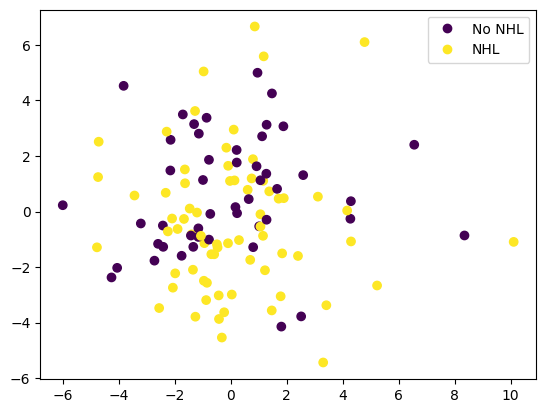

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
pca = PCA(n_components=.9, random_state=SEED)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=['No NHL', 'NHL'])
plt.show()

## function to get different types of cross validation

In [21]:
def get_cross_validation(X, y, test_size=.2, n_splits=10, type="stratified", random_state=SEED):
    if type == "stratified":
        return list(StratifiedShuffleSplit(test_size=test_size, n_splits=n_splits, random_state=random_state).split(X, y))
    elif type == "leave_one_out":
        return list(LeaveOneOut().split(X, y))
    elif type=="K-Fold":
        return list(KFold(n_splits=n_splits, random_state=random_state, shuffle=True).split(X, y))

In [22]:
def seaborn_conf_matrix(cm, model_name):
    plt.figure()
    plt.title(f"{model_name} Confusion Matrix")
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"../figures/confusion_matricies/{model_name}_conf_matrix.png")

## Tune SVM

In [23]:
import sklearn
print(sklearn.__version__)

1.2.2


In [24]:
def graph_cv_results(results_df):
    plt.figure()
    # Plot loss scores using seaborn
    
    plt.xticks(rotation=90)
    sns.lineplot(data=results_df, x='params', y='mean_train_score', label='CV Training Score')
    sns.lineplot(data=results_df, x='params', y='mean_test_score', label='CV Test Score')
    plt.xlabel('')
    plt.xticks(ticks=[], labels=[])

In [25]:
from sklearn.metrics import make_scorer

def overfitting_scorer(y_true, y_pred):
    # y_pred = clf.predict(X)
    score = f1_score(y_true, y_pred)
    return score

### Tune instance of model for 1 seed
Note: The decorator "@ray.remote" is useful to run different seeds in parallel using the ray python package

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score


@ray.remote
def tune_model(model, param_dist, features=None, n_iter=200, balance=True, weight_classes=False, target_col=None, random_state=SEED):


    X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col=target_col)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=random_state)
  
    cv = get_cross_validation(X_train, y_train, test_size=.2, n_splits=10, type="stratified", random_state=random_state)

    scaler = StandardScaler()
    if balance:
        pipe = ImbPipeline([
                ('smote', SMOTE(random_state=random_state)),
                ('scaler', scaler),
                ('selection', selector),
                ('model', model)
            ])
    else:
#         create pipeline
        pipe = ImbPipeline([
                ('scaler', "passthrough"),
                ('selector', "passthrough"),
                ('model', model)
            ])

#    setup hyperparameter search using Sklearn random search 
    random_search = RandomizedSearchCV(pipe, 
                                        param_distributions=param_dist, 
                                        cv=cv,
                                        n_iter=n_iter,
                                        random_state=random_state,
                                        return_train_score=True,
                                        scoring="f1",
                                        n_jobs=-1,
                                        refit=True)

#   run randomsearch looking for best param configuration on training data
    random_search.fit(X_train, y_train)
    
#   Once hyperparameter search is complete, predict on validation data using best configuration
# Note: since refit=True, randomsearch will automatically refit on all training data using best hyperparameters
    y_pred = random_search.predict(X_val)
    print(f"F1 score on Validation Set: {f1_score(y_val, y_pred)}")

#     return dataframe of metrics from random search 
    return pd.DataFrame([{
                            "Best Estimator" : random_search.best_estimator_,
                            "Best Score" : random_search.best_score_, 
                            "Best Params" : random_search.best_params_, 
                            "Validation Score" : f1_score(y_val, y_pred),
                            "Y Val (Validation)" : np.array(y_val),
                            "Y Pred (Validation)" : np.array(y_pred),
                            "Seed" : random_state,
                            "CV Train Mean" : float(pd.DataFrame.from_dict(random_search.cv_results_)["mean_train_score"].mean()), 
                            "CV Train STD" : float(pd.DataFrame.from_dict(random_search.cv_results_)["std_train_score"].mean()), 
                            "CV Test Mean" : float(pd.DataFrame.from_dict(random_search.cv_results_)["mean_test_score"].mean()),
                            "CV Test STD" : float(pd.DataFrame.from_dict(random_search.cv_results_)["std_test_score"].mean()),
                            }])
    

### Run training for different seeds in parallel

In [29]:
from time import time

def outer_tune_loop(model, param_dist, n_iter=None,target_col="NHL"):
    start = time()
    model_name = type(model).__name__
    if "Bagging" in model_name or "Ada" in model_name:
        model_name = model_name + "_" + model.estimator.__class__.__name__

    # random_states = [1, 10, 42, 69, 77, 11, 23, 99, 58, 91]
    random_states = [1, 10, 42, 69, 77]

    result_ids = [tune_model.remote(clone(model), param_dist, n_iter=n_iter, balance=False, weight_classes=False, target_col="NHL", random_state=random_states[i]) for i in range(len(random_states))]
    print(f"len result ids: {len(result_ids)}")
    outer_loop_results = pd.DataFrame()
    for random_search_cv_results in ray.get(result_ids):
        outer_loop_results = pd.concat([outer_loop_results, random_search_cv_results])

        
    print(f"Mean Validation Score Across {len(random_states)} trials: {round(outer_loop_results['Validation Score'].mean(), 3)}")
    outer_loop_results.to_excel(f"../{RESULTS_DIR}{model_name}.xlsx", index=False)
    print(f"Training time for {len(random_states)} seeds: {round(time() - start, 3)}")
    return outer_loop_results

### Start of model hyperparameter training
Note: Most models are in the order <br>
    1. Weak (plain / nonensemble) classifier <br>
    2. Bagging classifier (ensemble 1) <br>
    2. Boosting classifier (ensemble 2)

## SVC

## TODO 3
Play around with different feature selector / scaler combinations. Standard scaler is generally what most people use so I could imagine some exploration into picking that as the only scaler and then doing tuning. Same with the selector where we isolate one scaler/selector and then see if we get better or worse results. 

In [28]:
model = SVC(random_state=SEED)
param_dist = [
    {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__C': [.0001, .001, 1, 3, 5],
    'model__kernel': ['rbf', "linear", "poly", "sigmoid"],
    "model__class_weight" : [None, "balanced"]
    },
    
#     this might be a useful form you can also pass an array of dictionaries instead of just 1 dictionary 
    {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__C': [.0001, .001, 1, 3, 5],
    'model__kernel': ['rbf', "linear", "poly", "sigmoid"],
    "model__class_weight" : [None, "balanced"]
    },
    
    
]


svc_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
svc_cv_results


len result ids: 3
(tune_model pid=4075497) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=4075492) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=4075504) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=4075492) F1 score on Validation Set: 0.5882352941176471


(tune_model pid=4075492) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=4075492) 220 fits failed out of a total of 1000.
(tune_model pid=4075492) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=4075492) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=4075492) 
(tune_model pid=4075492) Below are more details about the failures:
(tune_model pid=4075492) --------------------------------------------------------------------------------
(tune_model pid=4075492) 220 fits failed with the following error:
(tune_model pid=4075492) Traceback (most recent call last):
(tune_model pid=4075492)   File "/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=4075

(tune_model pid=4075497) F1 score on Validation Set: 0.8


(tune_model pid=4075497) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=4075497) 190 fits failed out of a total of 1000.
(tune_model pid=4075497) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=4075497) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=4075497) 
(tune_model pid=4075497) Below are more details about the failures:
(tune_model pid=4075497) --------------------------------------------------------------------------------
(tune_model pid=4075497) 190 fits failed with the following error:
(tune_model pid=4075497) Traceback (most recent call last):
(tune_model pid=4075497)   File "/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=4075

Mean Validation Score Across 3 trials: 0.685
(tune_model pid=4075504) F1 score on Validation Set: 0.6666666666666666
Training time for 3 seeds: 70.205


(tune_model pid=4075504) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=4075504) 260 fits failed out of a total of 1000.
(tune_model pid=4075504) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=4075504) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=4075504) 
(tune_model pid=4075504) Below are more details about the failures:
(tune_model pid=4075504) --------------------------------------------------------------------------------
(tune_model pid=4075504) 260 fits failed with the following error:
(tune_model pid=4075504) Traceback (most recent call last):
(tune_model pid=4075504)   File "/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=4075

Best Estimator  \
0  (MinMaxScaler(), SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), SVC(C=1, kernel='sigmoid', random_state=42))   
0  (MinMaxScaler(), SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), SVC(C=3, kernel='sigmoid', random_state=42))   
0  (MinMaxScaler(), SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), SVC(C=3, kernel='sigmoid', random_state=42))   

   Best Score  \
0    0.767023   
0    0.768059   
0    0.732786   

                                                                                                                                                                                       Best Params  \
0  {'selector': SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), 'scaler': MinMaxScaler(), 'model__kernel': 'sigmoid', 'model__class_weight': None, 'model__C': 1}   
0  {'selector': SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), 'scaler': MinMaxScaler(), 'model__kernel': 'sigmoid', 'model__class_weight': None, 'model__C': 3}   
0  {'selector': SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), 'scaler': MinMaxScaler(), 'model__kernel': 'sigmoid', 'model__class_weight': None, 'model__C': 3}   

   Validation Score                    Y Val (Validation)  \
0          0.588235  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0          0.666667  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0          0.800000  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]   

                    Y Pred (Validation)  Seed  CV Train Mean  CV Train STD  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]     1       0.738830      0.015075   
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]    10       0.690577      0.032729   
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]    42       0.635577      0.022284   

   CV Test Mean  CV Test STD  
0      0.654310     0.047034  
0      0.609972     0.071218  
0      0.528016     0.054598

(tune_model pid=4075504) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=4075504)   warnings.warn(
(tune_model pid=4075504) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=4075504)   warnings.warn(
(tune_model pid=4075492) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=4075492)   warnings.warn(
(tune_model pid=4075492) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the numb

In [31]:
model = SVC(random_state=SEED)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__C': [.0001, .001, 1, 3, 5],
    'model__kernel': ['rbf', "linear", "poly", "sigmoid"],
    "model__class_weight" : [None, "balanced"]
}


svc_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
svc_cv_results


len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339485) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 160 is smaller than n_iter=200. Running 160 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 160 is smaller than n_iter=200. Running 160 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339485) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 160 is smaller than n_iter=200. Running 160 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=3339485)   warnings.w

(tune_model pid=3339485) F1 score on Validation Set: 0.7058823529411765
(tune_model pid=3339482) F1 score on Validation Set: 0.3636363636363636
(tune_model pid=3339481) F1 score on Validation Set: 0.42857142857142855
Mean Validation Score Across 3 trials: 0.499
Training time for 3 seeds: 127.251


Best Estimator  \
0  (None, passthrough, SVC(C=5, class_weight='balanced', random_state=42))   
0  (None, passthrough, SVC(C=1, class_weight='balanced', random_state=42))   
0     (None, passthrough, SVC(C=0.0001, kernel='linear', random_state=42))   

   Best Score  \
0    0.685714   
0    0.657143   
0    0.638095   

                                                                                    Best Params  \
0    {'scaler': None, 'model__kernel': 'rbf', 'model__class_weight': 'balanced', 'model__C': 5}   
0    {'scaler': None, 'model__kernel': 'rbf', 'model__class_weight': 'balanced', 'model__C': 1}   
0  {'scaler': None, 'model__kernel': 'linear', 'model__class_weight': None, 'model__C': 0.0001}   

   Validation Score                    Y Val (Validation)  \
0          0.428571  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0          0.363636  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0          0.705882  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]   

                    Y Pred (Validation)  Seed  CV Train Mean  CV Train STD  \
0  [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]     1       0.679256      0.035495   
0  [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]    10       0.669851      0.040275   
0  [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]    42       0.659807      0.029630   

   CV Test Mean  CV Test STD  
0      0.568333     0.064574  
0      0.559107     0.063602  
0      0.536845     0.064080

In [32]:
model = BaggingClassifier(estimator=SVC(random_state=SEED), random_state=SEED)
param_dist = {
        "selector" : [
                    None,
                    SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                    SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                    NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
            ],
        'scaler' : [StandardScaler(), None, MinMaxScaler(), RobustScaler()],
        'model__estimator__C': [.0001, .001, 1, 5],
        'model__estimator__kernel': ['linear', 'rbf', 'poly'],
        'model__n_estimators': [5, 10, 50],
        "model__estimator__class_weight" : [None, "balanced"]
    }

bagged_svc_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
bagged_svc_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339485) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339485) F1 score on Validation Set: 0.7058823529411765


(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_base.py

KeyboardInterrupt: 

In [116]:
model = AdaBoostClassifier(estimator=SVC(random_state=SEED), random_state=SEED, algorithm='SAMME')
param_dist = {
        "selector" : [
                    None,
                    SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                    SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                    NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
            ],
        'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        'model__estimator__C': [.0001, .001, 1, 5],
        'model__estimator__kernel': ['linear', 'rbf', 'poly',],
        'model__n_estimators': [5, 10, 50],
        "model__estimator__class_weight" : [None, "balanced"]
    }

boosted_svc_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
boosted_svc_cv_results

len result ids: 3
(tune_model pid=2327413) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=2327305) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=2327426) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=2327413) Index(['age', 'concussions', 'weight', 'bimanualscore_washer', 'RT_V', 'RT_HR',
(tune_model pid=2327413)        'Delta_RT', 'MT_V', 'MT_HR', 'Delta_MT', 'TMT_V', 'TMT_HR', 'CMT_V',
(tune_model pid=2327413)        'CMT_HR', 'cvRT_V', 'cvRT_HR', 'stdRT_V', 'stdRT_HR', 'BallPath_V',
(tune_model pid=2327413)        'BallPath_HR', 'FullPath_V', 'FullPath_HR', 'Delta_Fullpath',
(tune_model pid=2327413)        'Corrective_V', 'Corrective_HR', 'PeakV_V', 'PeakV_HR', 'Delta_PV',
(tune_model pid=2327413)        'AE_V', 'AE_HR', 'Delta_AE', 'VE_V', 'VE_HR', 'AbsOnAxis_HR',
(tune_model pid=2327413)        'Delta_OnAxis', 'AbsOffAxis_V', 'AbsOffAxis_HR', 'Delta_OffAxis',
(tune_model pid=2327413)        'AbsOnAxis_V'],

(tune_model pid=2327305) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=2327305) 119 fits failed out of a total of 500.
(tune_model pid=2327305) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=2327305) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=2327305) 
(tune_model pid=2327305) Below are more details about the failures:
(tune_model pid=2327305) --------------------------------------------------------------------------------
(tune_model pid=2327305) 119 fits failed with the following error:
(tune_model pid=2327305) Traceback (most recent call last):
(tune_model pid=2327305)   File "//home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=2327305)     estimator.fit(X_train, y_train, **fit_params)
(tune_model pid=

(tune_model pid=2327305) F1 score on Validation Set: 0.42857142857142855


(tune_model pid=2327426) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=2327426) 110 fits failed out of a total of 500.
(tune_model pid=2327426) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=2327426) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=2327426) 
(tune_model pid=2327426) Below are more details about the failures:
(tune_model pid=2327426) --------------------------------------------------------------------------------
(tune_model pid=2327426) 110 fits failed with the following error:
(tune_model pid=2327426) Traceback (most recent call last):
(tune_model pid=2327426)   File "//home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=2327426)     estimator.fit(X_train, y_train, **fit_params)
(tune_model pid=

(tune_model pid=2327426) F1 score on Validation Set: 0.625
Mean Validation Score Across 3 trials: 0.618
Training time for 3 seeds: 24.214


(tune_model pid=2327413) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=2327413) 166 fits failed out of a total of 500.
(tune_model pid=2327413) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=2327413) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=2327413) 
(tune_model pid=2327413) Below are more details about the failures:
(tune_model pid=2327413) --------------------------------------------------------------------------------
(tune_model pid=2327413) 166 fits failed with the following error:
(tune_model pid=2327413) Traceback (most recent call last):
(tune_model pid=2327413)   File "//home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=2327413)     estimator.fit(X_train, y_train, **fit_params)
(tune_model pid=

Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 (None, None, (SVC(C=0.0001, class_weight='balanced', kernel='linear', random_state=1608637542)))   
0                                                                                                                                                                                                                                                                                  (None, SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), (SVC(C=0.001, kernel='linear', random_state=1608637542), SVC(C=0.001, kernel='linear', random_state=1273642419), SVC(C=0.001, kernel='linear', random_state=1935803228), SVC(C=0.001, kernel='linear', random_state=787846414), SVC(C=0.001, kernel='linear', random_state=996406378)))   
0  (None, SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), (SVC(C=0.0001, kernel='linear', random_state=1608637542), SVC(C=0.0001, kernel='linear', random_state=1273642419), SVC(C=0.0001, kernel='linear', random_state=1935803228), SVC(C=0.0001, kernel='linear', random_state=787846414), SVC(C=0.0001, kernel='linear', random_state=996406378), SVC(C=0.0001, kernel='linear', random_state=1201263687), SVC(C=0.0001, kernel='linear', random_state=423734972), SVC(C=0.0001, kernel='linear', random_state=415968276), SVC(C=0.0001, kernel='linear', random_state=670094950), SVC(C=0.0001, kernel='linear', random_state=1914837113)))   

   Best Score  \
0    0.685714   
0    0.647619   
0    0.638095   

                                                                                                                                                                                                                                            Best Params  \
0                                                                       {'selector': None, 'scaler': None, 'model__n_estimators': 5, 'model__estimator__kernel': 'linear', 'model__estimator__class_weight': 'balanced', 'model__estimator__C': 0.0001}   
0  {'selector': SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), 'scaler': None, 'model__n_estimators': 50, 'model__estimator__kernel': 'linear', 'model__estimator__class_weight': None, 'model__estimator__C': 0.001}   
0                {'selector': SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), 'scaler': None, 'model__n_estimators': 10, 'model__estimator__kernel': 'linear', 'model__estimator__class_weight': None, 'model__estimator__C': 0.0001}   

   Validation Score                    Y Val (Validation)  \
0          0.428571  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0          0.625000  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0          0.800000  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]   

                    Y Pred (Validation)  Seed  CV Train Mean  CV Train STD  \
0  [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]     1       0.652857      0.024859   
0  [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]    10       0.649965      0.026255   
0  [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]    42       0.632579      0.020399   

   CV Test Mean  CV Test STD  
0      0.602449     0.044346  
0      0.594893     0.038210  
0      0.570476     0.046476

(tune_model pid=2327413) F1 score on Validation Set: 0.7999999999999999


(tune_model pid=2327305) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=2327305)   warnings.warn(
(tune_model pid=2327305) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=2327305)   warnings.warn(
(tune_model pid=2327305) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=2327305)   warnings.warn(
(tune_model pid=2327305) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=2327305)   warnings.warn(
(tune_model pid=2327413) //home/mmoschit/.local/lib/python3.8/site-packages/skle

## Light Gradient Boosting

In [ ]:
model = LGBMClassifier(random_state=SEED)
param_dist = {
        'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        "model__boosting_type": ["gbdt", "dart"],
        "model__num_leaves": [2, 5, 10, 20],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__max_depth": [1, 3, 5, 7],
        "model__min_child_samples": [1, 5, 10, 20],
        "model__subsample": [0.5, 0.7, 0.9],
        "model__colsample_bytree": [0.5, 0.7, 0.9],
        "model__class_weight" : ["balanced", None],
    }

lgbm_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
lgbm_cv_results

## TODO 2. 
I have yet to implement bagging and boosting version of both the light gradient boosting model (lightGBMClassifier) or elasticNet(logistic regression using elastic net solver). This could be done by following one of the existing implementations of BaggingClassifier or AdaBoostClassifier although I am not sure if they are compatible with lightGBM/elasticNet or if that makes sense to form ensemble classifiers out of lightGBM / elasticNet

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from mango import Tuner


X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=1)


# First step: define the search space of your algorithm
# usage of range instead of uniform to ensure integers

param_space = {'max_depth': range(3, 10),
               'min_samples_split': range(2, int(0.7*X_train.shape[0])),
               'min_samples_leaf': range(1, int(0.7*X_train.shape[0])),
               'max_features': ["sqrt", "log2", "auto"]
               }

# second step: define your objective function
# If you want to do cross validation, you define it inside the objective
# In this case, we use an analogous of a 1-fold cross validation.

from sklearn.model_selection import KFold

# define number of folds
n_splits = 5

# modify objective function to perform k-fold cross-validation
def objective(list_parameters):
    global X_train, y_train

    results = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for hyper_params in list_parameters:
        model = ExtraTreesClassifier(**hyper_params)
        errors = []
        for train_index, val_index in kf.split(X_train):
            x_train_fold, x_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model.fit(x_train_fold, y_train_fold)
            y_pred = model.predict(x_val_fold)
            error = f1_score(y_pred, y_val_fold)
            errors.append(error)
        results.append(np.mean(errors))
    return results

# third step: run the optimisation through Tuner
start_time = time()
tuner = Tuner(param_space, objective, dict(num_iteration=40, initial_random=10))  # Initialize Tuner
optimisation_results = tuner.minimize()
print(f'The optimisation in series takes {(time()-start_time)/60.} minutes.')

# Inspect the results
print('best parameters:', optimisation_results['best_params'])
print('best accuracy (f1):', optimisation_results['best_objective'])

# run the model with the best hyper-parameters on the test set
best_model = ExtraTreesClassifier(n_jobs=-1, **optimisation_results['best_params'])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)
print('f1 on test:', f1_score(y_pred, y_val))

/home/mmoschit/Concussions-and-Athletic-Performance/src


  0%|          | 0/40 [00:00<?, ?it/s]

The optimisation in series takes 1.0268454511960348 minutes.
best parameters: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 39}
best accuracy (f1): 0.702696797193951
f1 on test: 0.5882352941176471


## ElasticNet

In [35]:
model = LogisticRegression(random_state=SEED, max_iter=1000)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__l1_ratio': [0.5, .1, .01, .3, .7, .95],
    'model__penalty': ['elasticnet'],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced']
}

lr_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
lr_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
(tune_model pid=3339474)   warnings.warn(


Mean Validation Score Across 3 trials: 0.556
Training time for 3 seeds: 0.79


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(


Best Estimator  \
0                 (MinMaxScaler(), None, LogisticRegression(l1_ratio=0.7, max_iter=1000, penalty='elasticnet',\n                   random_state=42, solver='saga'))   
0  (None, None, LogisticRegression(class_weight='balanced', l1_ratio=0.5, max_iter=1000,\n                   penalty='elasticnet', random_state=42, solver='saga'))   
0                          (None, None, LogisticRegression(l1_ratio=0.95, max_iter=1000, penalty='elasticnet',\n                   random_state=42, solver='saga'))   

   Best Score  \
0    0.638095   
0    0.609524   
0    0.600000   

                                                                                                                                                  Best Params  \
0  {'selector': None, 'scaler': MinMaxScaler(), 'model__solver': 'saga', 'model__penalty': 'elasticnet', 'model__l1_ratio': 0.7, 'model__class_weight': None}   
0      {'selector': None, 'scaler': None, 'model__solver': 'saga', 'model__penalty': 'elasticnet', 'model__l1_ratio': 0.5, 'model__class_weight': 'balanced'}   
0           {'selector': None, 'scaler': None, 'model__solver': 'saga', 'model__penalty': 'elasticnet', 'model__l1_ratio': 0.95, 'model__class_weight': None}   

   Validation Score                    Y Val (Validation)  \
0          0.500000  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0          0.461538  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0          0.705882  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]   

                    Y Pred (Validation)  Seed  CV Train Mean  CV Train STD  \
0  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]     1       0.726290      0.034830   
0  [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]    10       0.721875      0.031348   
0  [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]    42       0.723958      0.032300   

   CV Test Mean  CV Test STD  
0      0.577778     0.077998  
0      0.581548     0.059044  
0      0.564484     0.103012

(tune_model pid=3339482) F1 score on Validation Set: 0.7058823529411765
(tune_model pid=3339481) F1 score on Validation Set: 0.4615384615384615
(tune_model pid=3339474) F1 score on Validation Set: 0.5000000000000001


## Decision Tree

In [37]:
model = DecisionTreeClassifier(random_state=SEED)
param_dist = {
        'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        "model__criterion" : ["gini", "entropy"],
        "model__max_depth" : [1, 3, 5, 10, 15],
        "model__min_samples_split" : [2, 5, 7, 9],
        "model__min_samples_leaf" : [1,2,5, 7, 9],
        "model__max_features" : ["sqrt", "log2", None],
        "model__class_weight" : ["balanced"],
    }

dt_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=150,target_col="NHL")
dt_cv_results


len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
Mean Validation Score Across 3 trials: 0.458
(tune_model pid=3339482) F1 score on Validation Set: 0.6666666666666667
(tune_model pid=3339481) F1 score on Validation Set: 0.7058823529411765
(tune_model pid=3339474) F1 score on Validation Set: 0.0
Training time for 3 seeds: 0.966


Best Estimator  \
0                       (RobustScaler(), passthrough, DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=10, max_features='log2', min_samples_leaf=9,\n                       random_state=42))   
0                                                                               (None, passthrough, DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,\n                       min_samples_split=5, random_state=42))   
0  (RobustScaler(), passthrough, DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=10, max_features='log2', min_samples_leaf=7,\n                       min_samples_split=5, random_state=42))   

   Best Score  \
0    0.590476   
0    0.628571   
0    0.600000   

                                                                                                                                                                                                        Best Params  \
0  {'scaler': RobustScaler(), 'model__min_samples_split': 2, 'model__min_samples_leaf': 9, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}   
0                  {'scaler': None, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 5, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}   
0  {'scaler': RobustScaler(), 'model__min_samples_split': 5, 'model__min_samples_leaf': 7, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}   

   Validation Score                    Y Val (Validation)  \
0          0.000000  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0          0.666667  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0          0.705882  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]   

                    Y Pred (Validation)  Seed  CV Train Mean  CV Train STD  \
0  [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]     1       0.768413      0.038589   
0  [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]    10       0.794587      0.031635   
0  [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]    42       0.765095      0.028202   

   CV Test Mean  CV Test STD  
0      0.517714     0.077967  
0      0.522476     0.081335  
0      0.490413     0.081508

In [38]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED)
param_dist = {
        "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        "model__n_estimators" : [5, 10, 50],
        "model__estimator__criterion" : ["gini", "entropy"],
        "model__estimator__max_depth" : range(1, 7),
        "model__estimator__min_samples_split" : range(2, 7),
        "model__estimator__min_samples_leaf" : range(1, 7),
        "model__estimator__max_features" : ["sqrt", "log2", None],
        "model__estimator__class_weight" : [None, "balanced"]
    }



bagged_dt_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
bagged_dt_cv_results


len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) F1 score on Validation Set: 0.6153846153846153
Mean Validation Score Across 3 trials: 0.631
Training time for 3 seeds: 1.378


Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            (StandardScaler(), passthrough, (DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1952926171), DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1761383086), DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1449071958), DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1910541088), DecisionTreeClassifier(max_depth=1, max_features='sqrt', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1341730541)))   
0  (MinMaxScaler(), passthrough, (DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1952926171), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1761383086), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1449071958), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1910541088), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1341730541), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1286572245), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=1005142668), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=502852014), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, random_state=186414760), DecisionTreeClassifier(class_weight='balanced', max_depth=6,\n                       max_features='log2', min_samples_leaf=5,\n                       min_samples_split=4, 

(tune_model pid=3339482) F1 score on Validation Set: 0.5000000000000001
(tune_model pid=3339481) F1 score on Validation Set: 0.7777777777777777


In [39]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED)
param_dist = {
        "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
        ],
        'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        "model__n_estimators" : [5, 10, 50],
        "model__estimator__criterion" : ["gini", "entropy"],
        "model__estimator__max_depth" : range(1, 7),
        "model__estimator__min_samples_split" : range(2, 7),
        "model__estimator__min_samples_leaf" : range(1, 7),
        "model__estimator__max_features" : ["sqrt", "log2", None],
        "model__estimator__class_weight" : [None, "balanced"]
    }


boosted_svc_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
boosted_svc_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
Mean Validation Score Across 3 trials: 0.463
(tune_model pid=3339482) F1 score on Validation Set: 0.42857142857142855
(tune_model pid=3339481) F1 score on Validation Set: 0.42857142857142855
(tune_model pid=3339474) F1 score on Validation Set: 0.5333333333333333
Training time for 3 seeds: 1.376


Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 (RobustScaler(), passthrough, (DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=1, max_features='log2', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1608637542), DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=1, max_features='log2', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1273642419), DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=1, max_features='log2', min_samples_leaf=3,\n                       min_samples_split=4, random_state=1935803228), DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=1, max_features='log2', min_samples_leaf=3,\n                       min_samples_split=4, random_state=787846414), DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n                       max_depth=1, max_features='log2', min_samples_leaf=3,\n                       min_samples_split=4, random_state=996406378)))   
0  (StandardScaler(), passthrough, (DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=1608637542), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=1273642419), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=1935803228), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=787846414), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=996406378), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=1201263687), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=423734972), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=415968276), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, random_state=670094950), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n                       max_features='log2', min_samples_leaf=2,\n                       min_samples_split=4, ra

## Random Forest

In [40]:
model = RandomForestClassifier(random_state=SEED)
param_dist = {
                "selector" : [
                        None,
                        SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                        SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                        NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                ],
                'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'model__n_estimators': [5, 10, 50],
                "model__max_depth" : range(1, 7),
                "model__min_samples_split" : range(2, 7),
                "model__min_samples_leaf" : range(2, 7),
                'model__max_features': ['sqrt', 'log2']}

rf_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
rf_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
Mean Validation Score Across 3 trials: 0.557
Training time for 3 seeds: 1.237


Best Estimator  \
0  (None, passthrough, (DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=1608637542), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=1273642419), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=1935803228), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=787846414), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=996406378), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=1201263687), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=423734972), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=415968276), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=670094950), DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=4,\n                       min_samples_split=5, random_state=1914837113)))   
0  (None, passthrough, (DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=1608637542), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=1273642419), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=1935803228), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=787846414), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=996406378), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=1201263687), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=423734972), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=415968276), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=670094950), DecisionTreeClassifier(max_depth=1, max_features='log2', min_samples_leaf=6,\n                       min_samples_split=4, random_state=1914837113)))   
0                                                                                                                                                                                                                    (None, passthrough, (DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,\n                       random_state=1608637542), DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,\n                       random_state=1273642419), DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,\n                       random_state=1935803228), DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,\n                       random_state=787846414), DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,\n                       random_state=996406378), DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,\n                       random_s

(tune_model pid=3339482) F1 score on Validation Set: 0.5333333333333333
(tune_model pid=3339481) F1 score on Validation Set: 0.4
(tune_model pid=3339474) F1 score on Validation Set: 0.7368421052631579


In [41]:
model = BaggingClassifier(estimator=RandomForestClassifier(random_state=SEED), random_state=SEED)
param_dist = {
            "selector" : [
                        None,
                        SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                        SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                        NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                ],
                'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                "model__n_estimators" : [5, 10, 50],
                'model__estimator__n_estimators': [5, 10, 50],
                "model__estimator__max_depth" : range(1, 7),
                "model__estimator__min_samples_split" : range(2, 7),
                "model__estimator__min_samples_leaf" : range(1, 7),
                'model__estimator__max_features': ['sqrt', 'log2'],
                "model__estimator__class_weight" : [None, "balanced"]
            }

bagged_rf_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
bagged_rf_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339482) F1 score on Validation Set: 0.5000000000000001
Mean Validation Score Across 3 trials: 0.593
(tune_model pid=3339481) F1 score on Validation Set: 0.5
(tune_model pid=3339474) F1 score on Validation Set: 0.7777777777777777
Training time for 3 seeds: 12.181


Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [44]:
model = AdaBoostClassifier(estimator=RandomForestClassifier(random_state=SEED), random_state=SEED)
param_dist = {
                "selector" : [
                        None,
                        SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
                        SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
                        NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
                ],
                'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                "model__n_estimators" : [5, 10, 50],
                'model__estimator__n_estimators': [5, 10, 50],
                "model__estimator__max_depth" : range(1, 7),
                "model__estimator__min_samples_split" : range(2, 7),
                "model__estimator__min_samples_leaf" : range(1, 7),
                'model__estimator__max_features': ['sqrt', 'log2'],
                "model__estimator__class_weight" : [None, "balanced"]
            }

boosted_rf_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
boosted_rf_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) F1 score on Validation Set: 0.4615384615384615
Mean Validation Score Across 3 trials: 0.619
(tune_model pid=3339482) F1 score on Validation Set: 0.5714285714285715
(tune_model pid=3339474) F1 score on Validation Set: 0.823529411764706
Training time for 3 seeds: 8.36


Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## MLP

In [45]:
model = MLPClassifier(random_state=SEED, max_iter=1000)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__hidden_layer_sizes': [(10,10,10), (5,10,5), (10,)],
    'model__alpha': [0.00001, .0001, .01, 1],
    'model__learning_rate_init': [0.00001, .0001, .01, 1],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['lbfgs', 'sgd', 'adam']
}

mlp_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
mlp_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) F1 score on Validation Set: 0.5000000000000001
(tune_model pid=3339481) F1 score on Validation Set: 0.8
Mean Validation Score Across 3 trials: 0.642
(tune_model pid=3339482) F1 score on Validation Set: 0.625
Training time for 3 seeds: 3.502


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
(tune_model pid=3339482) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(tune_model pid=3339482) 
(tune_model pid=3339482) Increase the number of iterations (max_iter) or scale the data as shown in:
(tune_model pid=3339482)     https://scikit-learn.org/stable/modules/preprocessing.html
(tune_model pid=3339482)   self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best Estimator  \
0  (None, passthrough, MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(5, 10, 5),\n              learning_rate_init=0.01, max_iter=1000, random_state=42,\n              solver='sgd'))   
0     (None, passthrough, MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(10,),\n              learning_rate_init=1e-05, max_iter=1000, random_state=42,\n              solver='lbfgs'))   
0   (None, passthrough, MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(5, 10, 5),\n              learning_rate_init=0.01, max_iter=1000, random_state=42,\n              solver='sgd'))   

   Best Score  \
0    0.647619   
0    0.638095   
0    0.619048   

                                                                                                                                                                Best Params  \
0  {'scaler': None, 'model__solver': 'sgd', 'model__learning_rate_init': 0.01, 'model__hidden_layer_sizes': (5, 10, 5), 'model__alpha': 1e-05, 'model__activation': 'tanh'}   
0     {'scaler': None, 'model__solver': 'lbfgs', 'model__learning_rate_init': 1e-05, 'model__hidden_layer_sizes': (10,), 'model__alpha': 0.01, 'model__activation': 'tanh'}   
0   {'scaler': None, 'model__solver': 'sgd', 'model__learning_rate_init': 0.01, 'model__hidden_layer_sizes': (5, 10, 5), 'model__alpha': 0.01, 'model__activation': 'tanh'}   

   Validation Score                    Y Val (Validation)  \
0             0.500  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0             0.625  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0             0.800  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]   

                    Y Pred (Validation)  Seed  CV Train Mean  CV Train STD  \
0  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]     1       0.739952      0.030622   
0  [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]    10       0.724738      0.032600   
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]    42       0.731024      0.025143   

   CV Test Mean  CV Test STD  
0      0.544190     0.078662  
0      0.530381     0.064217  
0      0.528190     0.067047

In [46]:
model = BaggingClassifier(estimator=MLPClassifier(random_state=SEED, max_iter=1000), random_state=SEED)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__n_estimators': [5, 10, 50],
    'model__estimator__hidden_layer_sizes': [(10,10,10), (5,10,5), (10,)],
    'model__estimator__alpha': [0.00001, .0001, .01, 1],
    'model__estimator__learning_rate_init': [0.00001, .0001, .01, 1],
    'model__estimator__activation': ['relu', 'tanh'],
    'model__estimator__solver': ['lbfgs', 'sgd', 'adam'],
}

bagged_mlp_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
bagged_mlp_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
(tune_model pid=3339482) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(tune_model pid=3339482) 
(tune_model pid=3339482) Increase the number of iterations (max_iter) or scale the data as shown in:
(tune_model pid=3339482)     https://scikit-learn.org/stable/modules/preprocessing.html
(tune_model pid=3339482)   self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neura

(tune_model pid=3339474) F1 score on Validation Set: 0.8


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
(tune_model pid=3339481) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(tune_model pid=3339481) 
(tune_model pid=3339481) Increase the number of iterations (max_iter) or scale the data as shown in:
(tune_model pid=3339481)     https://scikit-learn.org/stable/modules/preprocessing.html
(tune_model pid=3339481)   self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Perf

(tune_model pid=3339482) F1 score on Validation Set: 0.5882352941176471


(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
(tune_model pid=3339481) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(tune_model pid=3339481) 
(tune_model pid=3339481) Increase the number of iterations (max_iter) or scale the data as shown in:
(tune_model pid=3339481)     https://scikit-learn.org/stable/modules/preprocessing.html
(tune_model pid=3339481)   self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
(tune_model pid=3339481) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(tune_model pid=3339481) 
(tune_model pid=3339481) Increase the number of iterations (max_iter) or scal

(tune_model pid=3339481) F1 score on Validation Set: 0.5333333333333333
Mean Validation Score Across 3 trials: 0.641
Training time for 3 seeds: 72.986


Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

------
## Logistic Regression

In [151]:
model = LogisticRegression(random_state=SEED, max_iter=1000)
param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__C': [.0001, .001, 1, 3, 5],
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': [None, 'balanced']
}

lr_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
lr_cv_results

len result ids: 5
(tune_model pid=3769859) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3769864) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3769872) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3769806) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3769862) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3769862) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=3769862) 440 fits failed out of a total of 1000.
(tune_model pid=3769862) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=3769862) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=3769862) 
(tune_model pid=3769862) Below are more details about the failures:
(tune_model pid=3769862) --------------------------------------------------------------------------------
(tune_model pid=3769862) 120 fits failed with the following error:
(tune_model pid=3769862) Traceback (most recent call last):
(tune_model pid=3769862)   File "//home/mmoschit/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=3769862)     estimator.fit(X_train, y_train, **fit_params)
(tune_model pid

(tune_model pid=3769872) F1 score on Validation Set: 0.75
(tune_model pid=3769862) F1 score on Validation Set: 0.7692307692307692
(tune_model pid=3769859) F1 score on Validation Set: 0.3333333333333333
(tune_model pid=3769806) F1 score on Validation Set: 0.5


RaySystemError: System error: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/opt/anaconda3/lib/python3.8/site-packages/pandas/_libs/internals.cpython-38-x86_64-linux-gnu.so'>
traceback: Traceback (most recent call last):
  File "//home/mmoschit/.local/lib/python3.8/site-packages/ray/_private/serialization.py", line 369, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "//home/mmoschit/.local/lib/python3.8/site-packages/ray/_private/serialization.py", line 252, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "//home/mmoschit/.local/lib/python3.8/site-packages/ray/_private/serialization.py", line 207, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(pickle5_data)
  File "//home/mmoschit/.local/lib/python3.8/site-packages/ray/_private/serialization.py", line 195, in _deserialize_pickle5_data
    obj = pickle.loads(in_band, buffers=buffers)
AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/opt/anaconda3/lib/python3.8/site-packages/pandas/_libs/internals.cpython-38-x86_64-linux-gnu.so'>


(tune_model pid=3769864) F1 score on Validation Set: 0.75


In [49]:
model = BaggingClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)

param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__n_estimators': [5, 10, 50],
    'model__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'model__estimator__C': [.0001, .001, 1, 3, 5],
    'model__estimator__solver': ['liblinear', 'saga'],
    'model__estimator__class_weight': [None, 'balanced']
}

bagged_lr_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
bagged_lr_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=333948

(tune_model pid=3339482) F1 score on Validation Set: 0.5333333333333333


(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=3339481) 160 fits failed out of a total of 500.
(tune_model pid=3339481) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=3339481) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=3339481) 
(tune_model pid=3339481) Below are more details about the failures:
(tune_model pid=3339481) --------------------------------------------------------------------------------
(tune_model pid=3339481) 90 fits failed with the following error:
(tune_model pid=3339481) Traceback (most recent call last):
(tune_model pid=3339481)   File "/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=333948

(tune_model pid=3339481) F1 score on Validation Set: 0.5000000000000001
Mean Validation Score Across 3 trials: 0.619
(tune_model pid=3339474) F1 score on Validation Set: 0.823529411764706
Training time for 3 seeds: 15.586


(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=3339474) 140 fits failed out of a total of 500.
(tune_model pid=3339474) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=3339474) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=3339474) 
(tune_model pid=3339474) Below are more details about the failures:
(tune_model pid=3339474) --------------------------------------------------------------------------------
(tune_model pid=3339474) 45 fits failed with the following error:
(tune_model pid=3339474) Traceback (most recent call last):
(tune_model pid=3339474)   File "/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=333947

Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        (None, SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), (LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1952926171,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1761383086,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1449071958,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1910541088,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1341730541,\n                   solver='saga')))   
0                           (None, SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), (LogisticRegression(C=0.0001, max_iter=1000, random_state=1952926171,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1761383086,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1449071958,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1910541088,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1341730541,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1286572245,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1005142668,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=502852014,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=186414760,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1956263048,\n                   solver='saga')))   
0  (None, SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), (LogisticRegression(C=0.001, max_iter=1000, random_state=1952926171,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1761383086,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1449071958,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1910541088,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1341730541,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1286572245,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1005142668,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=502852014,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=186414760,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1956263048,\n                   solver='liblinear')))   

   Best Score  \
0    0.647619   
0    0.657143   
0    0.609524   

                                                                                                                                                                                                                                                                              Best Params  \
0                       {'selector': SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), 'scaler': None, '

In [50]:
model = AdaBoostClassifier(estimator=LogisticRegression(random_state=SEED, max_iter=1000), random_state=SEED)

param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__n_estimators': [5, 10, 50],
    'model__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'model__estimator__C': [.0001, .001, 1, 3, 5],
    'model__estimator__solver': ['liblinear', 'saga'],
    'model__estimator__class_weight': [None, 'balanced']
}

boosted_lr_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
bagged_lr_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reach

(tune_model pid=3339481) F1 score on Validation Set: 0.625


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reach

(tune_model pid=3339474) F1 score on Validation Set: 0.5714285714285714


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=3339482)   warnings.warn(
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the numb

Mean Validation Score Across 3 trials: 0.649
(tune_model pid=3339482) F1 score on Validation Set: 0.75
Training time for 3 seeds: 52.077


(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
(tune_model pid=3339482) 140 fits failed out of a total of 500.
(tune_model pid=3339482) The score on these train-test partitions for these parameters will be set to nan.
(tune_model pid=3339482) If these failures are not expected, you can try to debug them by setting error_score='raise'.
(tune_model pid=3339482) 
(tune_model pid=3339482) Below are more details about the failures:
(tune_model pid=3339482) --------------------------------------------------------------------------------
(tune_model pid=3339482) 45 fits failed with the following error:
(tune_model pid=3339482) Traceback (most recent call last):
(tune_model pid=3339482)   File "/home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
(tune_model pid=333948

Best Estimator  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        (None, SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), (LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1952926171,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1761383086,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1449071958,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1910541088,\n                   solver='saga'), LogisticRegression(C=3, max_iter=1000, penalty='l1', random_state=1341730541,\n                   solver='saga')))   
0                           (None, SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), (LogisticRegression(C=0.0001, max_iter=1000, random_state=1952926171,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1761383086,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1449071958,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1910541088,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1341730541,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1286572245,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1005142668,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=502852014,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=186414760,\n                   solver='saga'), LogisticRegression(C=0.0001, max_iter=1000, random_state=1956263048,\n                   solver='saga')))   
0  (None, SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), (LogisticRegression(C=0.001, max_iter=1000, random_state=1952926171,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1761383086,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1449071958,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1910541088,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1341730541,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1286572245,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1005142668,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=502852014,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=186414760,\n                   solver='liblinear'), LogisticRegression(C=0.001, max_iter=1000, random_state=1956263048,\n                   solver='liblinear')))   

   Best Score  \
0    0.647619   
0    0.657143   
0    0.609524   

                                                                                                                                                                                                                                                                              Best Params  \
0                       {'selector': SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), 'scaler': None, '

------
## XGB

In [51]:


model = XGBClassifier(random_state=SEED)

param_dist = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler' : [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [50, 100, 200],
    'model__gamma': [0, 0.1, 0.2],
    'model__subsample': [0.5, 0.8, 1.0],
    'model__colsample_bytree': [0.5, 0.8, 1.0]
}


xgb_cv_results = outer_tune_loop(model=model, param_dist=param_dist, n_iter=100,target_col="NHL")
xgb_cv_results

len result ids: 3
(tune_model pid=3339482) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/src
(tune_model pid=3339474) /home/mmoschit/Concussions-and-Athletic-Performance/src


(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3339481)   warnings.warn(
(tune_model pid=3339481) /home/mmoschit/Concussions-and-Athletic-Performance/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reach

(tune_model pid=3339481) F1 score on Validation Set: 0.6666666666666666
(tune_model pid=3339482) F1 score on Validation Set: 0.5333333333333333
Mean Validation Score Across 3 trials: 0.578
Training time for 3 seeds: 3.144
(tune_model pid=3339474) F1 score on Validation Set: 0.5333333333333333


Best Estimator  \
0  (RobustScaler(), SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.5, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.01, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=3, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=42, ...))   
0                  (RobustScaler(), SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.5, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.01, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=7, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=50, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=42, ...))   
0            (None, SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.8, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.1, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=7, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=50, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=42, ...))   

   Best Score  \
0    0.657143   
0    0.609524   
0    0.600000   

                                                                                                                                                                                                                                                                            Best Params  \
0  {'selector': SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), 'scaler': RobustScaler(), 'model__subsample': 1.0, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__gamma': 0, 'model__colsample_bytree': 0.5}   
0                  {'selector': SelectFromModel(estimator=ExtraTreesClassifier(random_state=42)), 'scaler': RobustScaler(), 'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__gamma': 0, 'model__colsample_bytree': 0.5}   
0            {'selector': SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42)), 'scaler': None, 'model__subsample': 0.5, 'model__n_estimators': 50, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0.2, 'model__colsample_bytree': 0.8}   

   Validation Score                    Y Val (Validation)  \
0          0.533333  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]   
0          0.533333  [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]   
0          0.666667  [

## TODO 1
Compare bayesian optomization for hyperparameter tuning with random search. Can we setup the code below so that is the same as what is displayed in tune_model and compare the results. 

The cell below is scratch work that I started recently that attempts to use a new technique for hyperparameter tuning (HT). Right now we use randomSearch for HT that randomly tries combinations from the search space. Another approach is bayesian optimization. The one-sentence summary of [Bayesian hyperparameter optimization is](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f#:~:text=The%20one%2Dsentence%20summary%20of%20Bayesian%20hyperparameter%20optimization%20is%3A%20build%20a%20probability%20model%20of%20the%20objective%20function%20and%20use%20it%20to%20select%20the%20most%20promising%20hyperparameters%20to%20evaluate%20in%20the%20true%20objective%20function.): build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

One of the issues we run into is [overtraining](https://vortarus.com/machine-learning-overtraining/). I found that I was overtraining with random search as I was running it for so many iterations that it was able to find params that fit the training data really really well. You'll see that most times outer_tune_loop is called with n_iter=100. This is the function argument that controls how many times random search is run. Might also be something to play around with. 

This cell was pretty much scratch work that I just started. I should have a working version in a different branch if you have trouble with this. 


In [152]:
from pprint import pprint


X, y = create_dataset(clean_raw_data(f"../{DATA_DIR}Brdi_db_march.xlsx"), target_col="NHL")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42)

param_space = {
    "selector" : [
            None,
            SelectFromModel(LinearSVC(random_state=SEED, penalty="l1", dual=False)),
            SelectFromModel(ExtraTreesClassifier(random_state=SEED)), 
            NamedFeatureSelector(["Delta_MT", "Delta_AE", "cvRT_HR", "Corrective_HR", "RT_V", "age"]),
    ],
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
    'model__boosting_type': ["gbdt", "dart"],
    'model__num_leaves': [2, 5, 10, 20],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [1, 3, 5, 7],
    'model__min_child_samples': [1, 5, 10, 20],
    'model__subsample': [0.5, 0.7, 0.9],
    'model__colsample_bytree': [0.5, 0.7, 0.9],
    'model__class_weight': ["balanced", None]
}

pipeline = Pipeline(
    [
        ('scaler', 'passthrough'),
#         ('selector', 'passthrough'),
        ('model', LGBMClassifier(random_state=42))
    ])

# Define the objective function to optimize
def objective(list_parameters):
    
   
    
    global X_train, y_train, pipeline

    results = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv = get_cross_validation(X_train, y_train, test_size=.2, n_splits=5, type="stratified", random_state=42)
#     kf = StratifiedShuffleSplit(test_size=.2, n_splits=10, random_state=42)

    for hyper_params in list_parameters:
        pipeline.set_params(**dict(hyper_params))
        errors = []
        for train_index, val_index in cv:
            x_train_fold, x_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            pipeline.fit(x_train_fold, y_train_fold)
            y_pred = pipeline.predict(x_val_fold)
            error = f1_score(y_pred, y_val_fold)
            print(f"Cross validation Score: {error}")
            errors.append(error)
        results.append(np.mean(errors))
    return results

# Initialize the tuner
tuner = Tuner(param_space, objective, {"initial_random": 10, "num_iteration": 100})

# Run the optimization
optimization_results = tuner.minimize()

# Print the best hyperparameters and score
print('best parameters:', optimization_results['best_params'])
print('best accuracy (f1):', optimization_results['best_objective'])

# Train the best model on the full training set and evaluate on the validation set
pipeline.set_params(**optimization_results['best_params'])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('f1 on test:', f1_score(y_pred, y_val))

/home/mmoschit/Concussions-and-Athletic-Performance/src


ValueError: Invalid parameter 'selector' for estimator Pipeline(steps=[('scaler', RobustScaler()),
                ('model', LGBMClassifier(random_state=42))]). Valid parameters are: ['memory', 'steps', 'verbose'].

(tune_model pid=3769859) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=3769859)   warnings.warn(
(tune_model pid=3769859) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tune_model pid=3769859)   warnings.warn(
(tune_model pid=3769859) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3769859)   warnings.warn(
(tune_model pid=3769806) //home/mmoschit/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(tune_model pid=3769806)   warnings.warn(
(tune_model pid=3769862) //home/mmoschit/.local/lib/python3.8/site-p

-----
## Collect Results

In [54]:
import os 
from scipy import stats

model_results = pd.DataFrame()
ensemble_results = pd.DataFrame()
for file_name in os.listdir("../results"):
    df = pd.read_excel(f"../results/{file_name}", index_col=0).reset_index()
    df = df[["Validation Score", "CV Train Mean", "CV Train STD", "CV Test Mean", "CV Test STD", "Y Val (Validation)", "Y Pred (Validation)"]]
    # df = df[["Validation Score", "Test"]]
    df.index=[os.path.splitext(file_name)[0]] * len(df)

    df["Validation Z Score"] = np.abs(stats.zscore(df["Validation Score"]))
    # df = df[df["Validation Z Score"] < 1.7]

    if "Bagging" in file_name or "Ada" in file_name:
        ensemble_results = pd.concat([ensemble_results, df])
    else:
        model_results = pd.concat([model_results, df])
    


In [55]:
model_results

Validation Score  CV Train Mean  CV Train STD  \
DecisionTreeClassifier          0.000000       0.768413      0.038589   
DecisionTreeClassifier          0.666667       0.794587      0.031635   
DecisionTreeClassifier          0.705882       0.765095      0.028202   
LogisticRegression              0.428571       0.672098      0.027576   
LogisticRegression              0.625000       0.671808      0.026267   
LogisticRegression              0.750000       0.645465      0.032569   
MLPClassifier                   0.500000       0.739952      0.030622   
MLPClassifier                   0.625000       0.724738      0.032600   
MLPClassifier                   0.800000       0.731024      0.025143   
RandomForestClassifier          0.400000       0.826976      0.025313   
RandomForestClassifier          0.533333       0.821643      0.021361   
RandomForestClassifier          0.736842       0.823333      0.028581   
SVC                             0.428571       0.679256      0.035495   
SVC                             0.363636       0.669851      0.040275   
SVC                             0.705882       0.659807      0.029630   
XGBClassifier                   0.533333       0.981833      0.005770   
XGBClassifier                   0.533333       0.979214      0.005097   
XGBClassifier                   0.666667       0.981381      0.007273   
LGBMClassifier                  0.571429       0.873095      0.019537   
LGBMClassifier                  0.705882       0.876214      0.017323   
LGBMClassifier                  0.842105       0.912524      0.015697   

                        CV Test Mean  CV Test STD         Y Val (Validation)  \
DecisionTreeClassifier      0.517714     0.077967  [1 0 0 1 0 0 1 1 0 1 0 0]   
DecisionTreeClassifier      0.522476     0.081335  [1 0 1 0 0 0 0 1 1 0 1 1]   
DecisionTreeClassifier      0.490413     0.081508  [1 0 1 1 1 1 0 1 0 1 0 1]   
LogisticRegression          0.568899     0.057669  [1 0 0 1 0 0 1 1 0 1 0 0]   
LogisticRegression          0.562043     0.058621  [1 0 1 0 0 0 0 1 1 0 1 1]   
LogisticRegression          0.541345     0.091487  [1 0 1 1 1 1 0 1 0 1 0 1]   
MLPClassifier               0.544190     0.078662  [1 0 0 1 0 0 1 1 0 1 0 0]   
MLPClassifier               0.530381     0.064217  [1 0 1 0 0 0 0 1 1 0 1 1]   
MLPClassifier               0.528190     0.067047  [1 0 1 1 1 1 0 1 0 1 0 1]   
RandomForestClassifier      0.579429     0.061221  [1 0 0 1 0 0 1 1 0 1 0 0]   
RandomForestClassifier      0.562952     0.054351  [1 0 1 0 0 0 0 1 1 0 1 1]   
RandomForestClassifier      0.512952     0.074189  [1 0 1 1 1 1 0 1 0 1 0 1]   
SVC                         0.568333     0.064574  [1 0 0 1 0 0 1 1 0 1 0 0]   
SVC                         0.559107     0.063602  [1 0 1 0 0 0 0 1 1 0 1 1]   
SVC                         0.536845     0.064080  [1 0 1 1 1 1 0 1 0 1 0 1]   
XGBClassifier               0.586762     0.060148  [1 0 0 1 0 0 1 1 0 1 0 0]   
XGBClassifier               0.536286     0.066614  [1 0 1 0 0 0 0 1 1 0 1 1]   
XGBClassifier               0.523429     0.093899  [1 0 1 1 1 1 0 1 0 1 0 1]   
LGBMClassifier              0.575905     0.058993  [1 0 0 1 0 0 1 1 0 1 0 0]   
LGBMClassifier              0.543238     0.056239  [1 0 1 0 0 0 0 1 1 0 1 1]   
LGBMClassifier              0.497333     0.091326  [1 0 1 1 1 1 0 1 0 1 0 1]   

                              Y Pred (Validation)  Validation Z Score  
DecisionTreeClassifier  [0 1 1 0 1 0 0 0 0 0 1 1]            1.412485  
DecisionTreeClassifier  [1 1 1 1 1 0 1 1 1 0 0 1]            0.645707  
DecisionTreeClassifier  [1 0 1 1 1 0 1 1 1 0 1 1]            0.766778  
LogisticRegression      [1 0 1 0 1 1 1 1 1 0 1 1]            1.304772  
LogisticRegression      [1 1 1 1 1 0 1 1 0 1 1 1]            0.179969  
LogisticRegression      [1 0 1 1 1 1 1 0 1 0 0 1]            1.124803  
MLPClassifier           [1 1 1 0 1 1 1 1 1 1 1 1]            1.151385  
MLPClassifier           [1 1 1 1 1 0 1 1 0 1 1 1]            0.135457  
MLPClass

In [56]:
ensemble_results

Validation Score  CV Train Mean  \
AdaBoostClassifier_DecisionTreeClassifier          0.428571       0.976762   
AdaBoostClassifier_DecisionTreeClassifier          0.428571       0.973381   
AdaBoostClassifier_DecisionTreeClassifier          0.533333       0.983952   
AdaBoostClassifier_LogisticRegression              0.571429       0.568277   
AdaBoostClassifier_LogisticRegression              0.625000       0.601207   
AdaBoostClassifier_LogisticRegression              0.750000       0.603671   
AdaBoostClassifier_RandomForestClassifier          0.461538       0.973762   
AdaBoostClassifier_RandomForestClassifier          0.571429       0.979238   
AdaBoostClassifier_RandomForestClassifier          0.823529       0.983452   
AdaBoostClassifier_SVC                             0.428571       0.652857   
AdaBoostClassifier_SVC                             0.625000       0.649965   
AdaBoostClassifier_SVC                             0.800000       0.632579   
BaggingClassifier_DecisionTreeClassifier           0.500000       0.862643   
BaggingClassifier_DecisionTreeClassifier           0.615385       0.835619   
BaggingClassifier_DecisionTreeClassifier           0.777778       0.855048   
BaggingClassifier_LogisticRegression               0.500000       0.672759   
BaggingClassifier_LogisticRegression               0.533333       0.676256   
BaggingClassifier_LogisticRegression               0.823529       0.650496   
BaggingClassifier_MLPClassifier                    0.588235       0.797929   
BaggingClassifier_MLPClassifier                    0.533333       0.769381   
BaggingClassifier_MLPClassifier                    0.800000       0.742762   
BaggingClassifier_RandomForestClassifier           0.500000       0.813024   
BaggingClassifier_RandomForestClassifier           0.500000       0.808571   
BaggingClassifier_RandomForestClassifier           0.777778       0.851405   
BaggingClassifier_SVC                              0.533333       0.670452   
BaggingClassifier_SVC                              0.500000       0.689524   
BaggingClassifier_SVC                              0.777778       0.673810   

                                           CV Train STD  CV Test Mean  \
AdaBoostClassifier_DecisionTreeClassifier      0.003728      0.549524   
AdaBoostClassifier_DecisionTreeClassifier      0.004984      0.532952   
AdaBoostClassifier_DecisionTreeClassifier      0.003777      0.489524   
AdaBoostClassifier_LogisticRegression          0.025285      0.532633   
AdaBoostClassifier_LogisticRegression          0.024471      0.544162   
AdaBoostClassifier_LogisticRegression          0.024231      0.538624   
AdaBoostClassifier_RandomForestClassifier      0.006782      0.576667   
AdaBoostClassifier_RandomForestClassifier      0.006813      0.517333   
AdaBoostClassifier_RandomForestClassifier      0.005502      0.532000   
AdaBoostClassifier_SVC                         0.024859      0.602449   
AdaBoostClassifier_SVC                         0.026255      0.594893   
AdaBoostClassifier_SVC                         0.020399      0.570476   
BaggingClassifier_DecisionTreeClassifier       0.023241      0.569048   
BaggingClassifier_DecisionTreeClassifier       0.024323      0.548571   
BaggingClassifier_DecisionTreeClassifier       0.028058      0.503333   
BaggingClassifier_LogisticRegression           0.029861      0.572129   
BaggingClassifier_LogisticRegression           0.031927      0.559817   
BaggingClassifier_LogisticRegression           0.029092      0.537037   
BaggingClassifier_MLPClassifier                0.022341      0.574381   
BaggingClassifier_MLPClassifier                0.019418      0.555524   
BaggingClassifier_MLPClassifier                0.021843      0.543429   
BaggingClassifier_RandomForestClassifier       0.022639      0.588762   
BaggingClassifier_RandomForestClassifier       0.027571      0.547238   
BaggingClassifier_RandomForestClassifier       0.024183      0.527810   
BaggingClassifier_SVC            

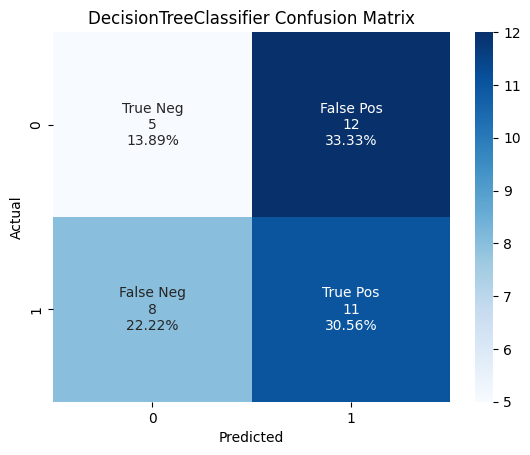

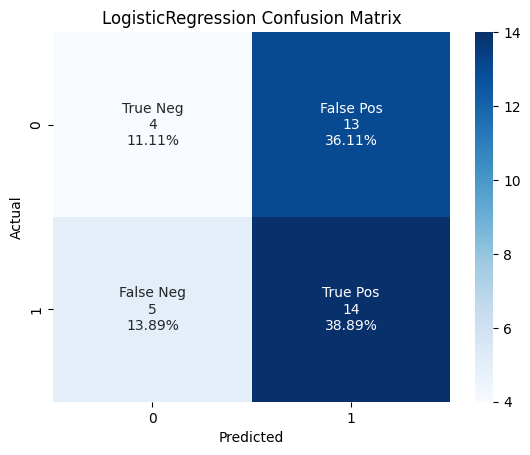

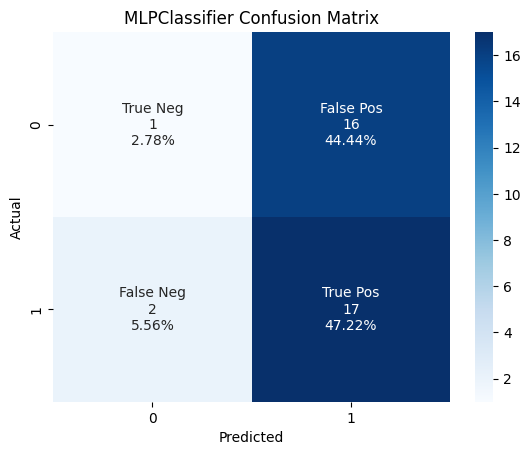

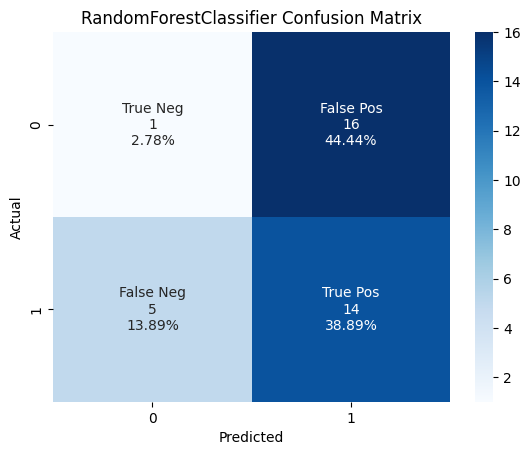

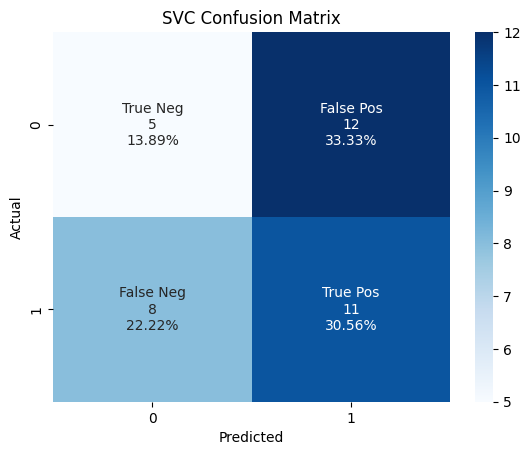

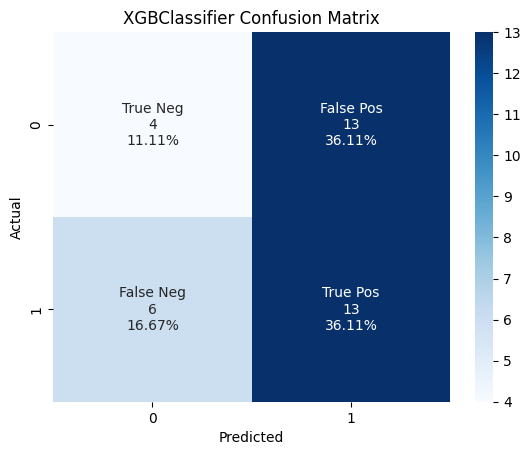

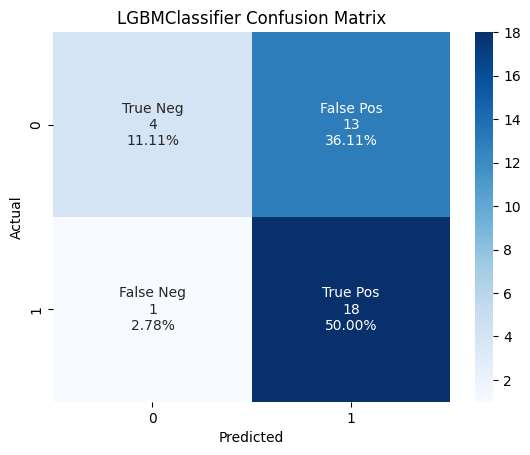

In [58]:
from ast import literal_eval
# Get the confusion matrices for each model

def get_confusion_matrices(df):
    models = df.index.unique()

    for model_name in models:
        y_pred = []
        y_val = []

        model_df = df.loc[model_name]
        for index, row in model_df.iterrows():
            y_pred.extend(literal_eval(row["Y Pred (Validation)"].replace(' ', ",")))
            y_val.extend(literal_eval(row["Y Val (Validation)"].replace(' ', ",")))


        
        seaborn_conf_matrix(confusion_matrix(y_val, y_pred), model_name)


get_confusion_matrices(model_results)

        


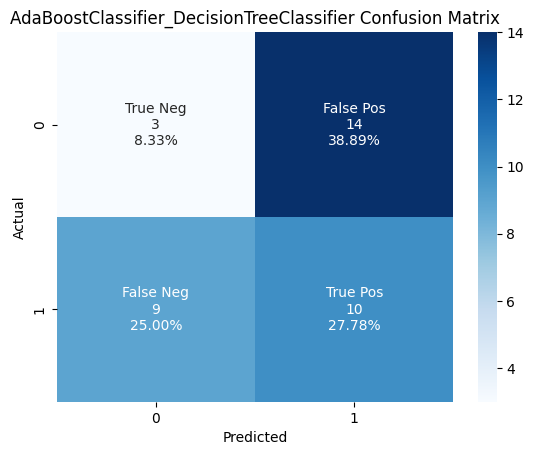

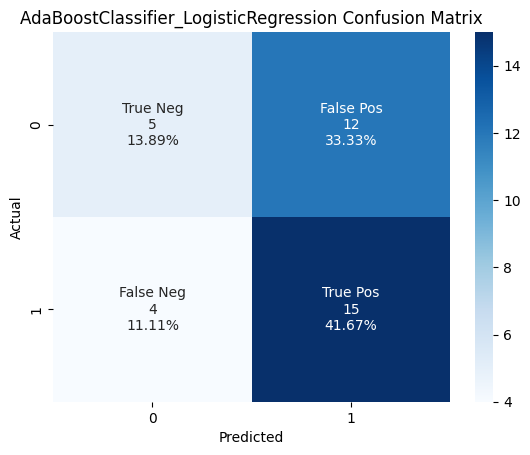

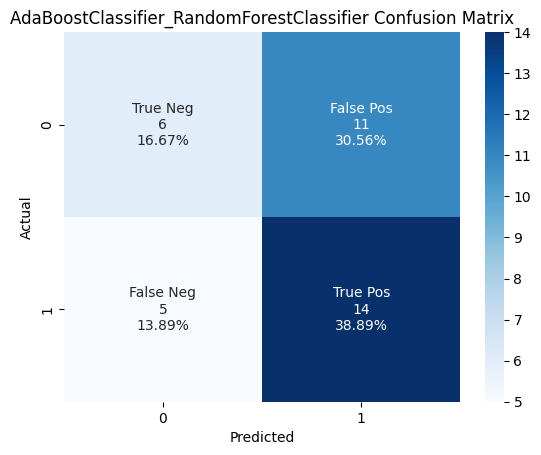

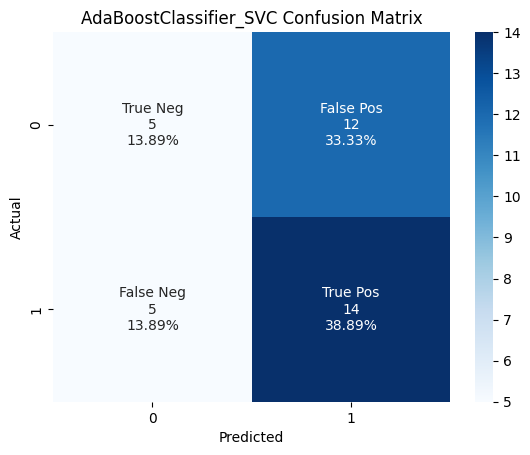

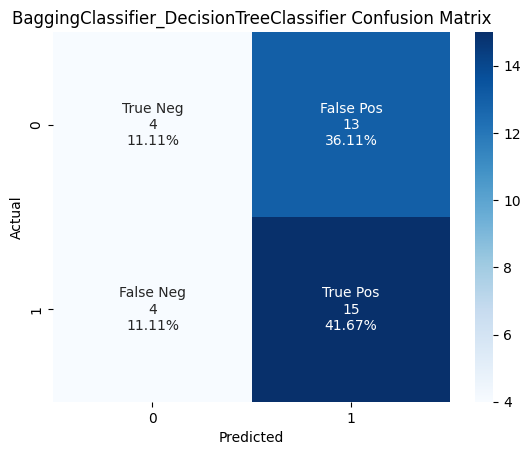

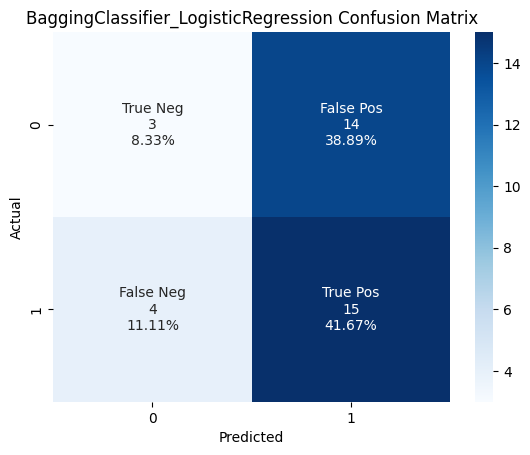

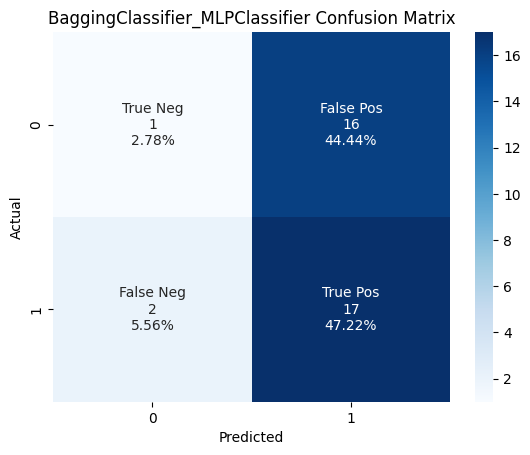

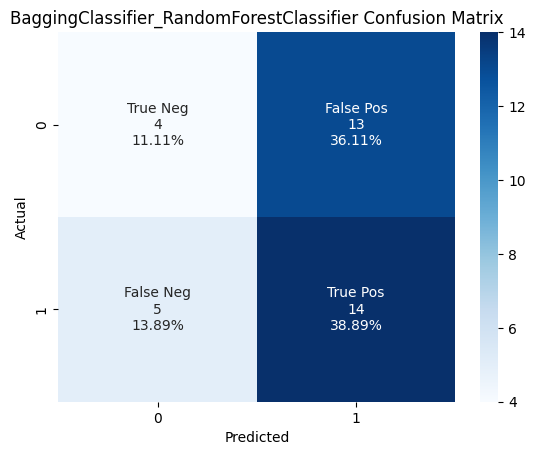

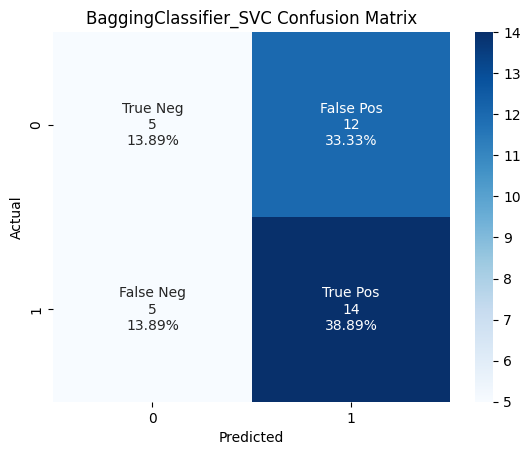

In [59]:
get_confusion_matrices(ensemble_results)

In [60]:
avg_model_results = model_results.groupby(model_results.index).mean(numeric_only=True).sort_values("Validation Score", ascending=False)
avg_model_results.columns = list(map(lambda x: "Mean " + x,avg_model_results.columns))
avg_model_results

Mean Validation Score  Mean CV Train Mean  \
LGBMClassifier                       0.706472            0.887278   
MLPClassifier                        0.641667            0.731905   
LogisticRegression                   0.601190            0.663124   
XGBClassifier                        0.577778            0.980810   
RandomForestClassifier               0.556725            0.823984   
SVC                                  0.499363            0.669638   
DecisionTreeClassifier               0.457516            0.776032   

                        Mean CV Train STD  Mean CV Test Mean  \
LGBMClassifier                   0.017519           0.538825   
MLPClassifier                    0.029455           0.534254   
LogisticRegression               0.028804           0.557429   
XGBClassifier                    0.006047           0.548825   
RandomForestClassifier           0.025085           0.551778   
SVC                              0.035133           0.554762   
DecisionTreeClassifier           0.032809           0.510201   

                        Mean CV Test STD  Mean Validation Z Score  
LGBMClassifier                  0.068853                 0.818270  
MLPClassifier                   0.069975                 0.857895  
LogisticRegression              0.069259                 0.869848  
XGBClassifier                   0.073554                 0.942809  
RandomForestClassifier          0.063254                 0.866949  
SVC                             0.064085                 0.927648  
DecisionTreeClassifier          0.080270                 0.941657

In [62]:
avg_ensemble_results = ensemble_results.groupby(ensemble_results.index).mean(numeric_only=True).sort_values("Validation Score", ascending=False)
avg_ensemble_results.columns = list(map(lambda x: "Mean " + x,avg_ensemble_results.columns))
avg_ensemble_results

Mean Validation Score  \
AdaBoostClassifier_LogisticRegression                   0.648810   
BaggingClassifier_MLPClassifier                         0.640523   
BaggingClassifier_DecisionTreeClassifier                0.631054   
BaggingClassifier_LogisticRegression                    0.618954   
AdaBoostClassifier_RandomForestClassifier               0.618832   
AdaBoostClassifier_SVC                                  0.617857   
BaggingClassifier_SVC                                   0.603704   
BaggingClassifier_RandomForestClassifier                0.592593   
AdaBoostClassifier_DecisionTreeClassifier               0.463492   

                                           Mean CV Train Mean  \
AdaBoostClassifier_LogisticRegression                0.591052   
BaggingClassifier_MLPClassifier                      0.770024   
BaggingClassifier_DecisionTreeClassifier             0.851103   
BaggingClassifier_LogisticRegression                 0.666504   
AdaBoostClassifier_RandomForestClassifier            0.978817   
AdaBoostClassifier_SVC                               0.645134   
BaggingClassifier_SVC                                0.677929   
BaggingClassifier_RandomForestClassifier             0.824333   
AdaBoostClassifier_DecisionTreeClassifier            0.978032   

                                           Mean CV Train STD  \
AdaBoostClassifier_LogisticRegression               0.024662   
BaggingClassifier_MLPClassifier                     0.021201   
BaggingClassifier_DecisionTreeClassifier            0.025207   
BaggingClassifier_LogisticRegression                0.030293   
AdaBoostClassifier_RandomForestClassifier           0.006366   
AdaBoostClassifier_SVC                              0.023838   
BaggingClassifier_SVC                               0.032533   
BaggingClassifier_RandomForestClassifier            0.024798   
AdaBoostClassifier_DecisionTreeClassifier           0.004163   

                                           Mean CV Test Mean  \
AdaBoostClassifier_LogisticRegression               0.538473   
BaggingClassifier_MLPClassifier                     0.557778   
BaggingClassifier_DecisionTreeClassifier            0.540317   
BaggingClassifier_LogisticRegression                0.556328   
AdaBoostClassifier_RandomForestClassifier           0.542000   
AdaBoostClassifier_SVC                              0.589273   
BaggingClassifier_SVC                               0.544159   
BaggingClassifier_RandomForestClassifier            0.554603   
AdaBoostClassifier_DecisionTreeClassifier           0.524000   

                                           Mean CV Test STD  \
AdaBoostClassifier_LogisticRegression              0.055330   
BaggingClassifier_MLPClassifier                    0.063917   
BaggingClassifier_DecisionTreeClassifier           0.073236   
BaggingClassifier_LogisticRegression               0.062933   
AdaBoostClassifier_RandomForestClassifier          0.063920   
AdaBoostClassifier_SVC                             0.043011   
BaggingClassifier_SVC                              0.060105   
BaggingClassifier_RandomForestClassifier           0.063233   
AdaBoostClassifier_DecisionTreeClassifier          0.079310   

                                           Mean Validation Z Score  
AdaBoostClassifier_LogisticRegression                     0.901632  
BaggingClassifier_MLPClassifier                           0.924720  
BaggingClassifier_DecisionTreeClassifier                  0.858467  
BaggingClassifier_LogisticRegression                      0.938665  
AdaBoostClassifier_RandomForestClassifier                 0.900545  
AdaBoostClassifier_SVC                                    0.831737  
BaggingClassifier_SVC                                     0.937099  
BaggingClassifier_RandomForestClassifier                  0.942809  
AdaBoostClassifier_DecisionTreeClassifier                 0.942809

In [31]:
avg_ensemble_results = avg_ensemble_results[["Mean Validation Score", "Mean Validation Z Score","Mean CV Train Mean", "Mean CV Test Mean"]]
avg_ensemble_results.columns = ["Val F1", "Val Z-Score","Train F1", "Test F1"]
avg_ensemble_results.index = list(map(lambda x: x.replace("BaggingClassifier", "Bagging").replace("AdaBoostClassifier", "AdaBoost").replace("_", "-"), avg_ensemble_results.index))
avg_ensemble_results.loc["Mean"] = avg_ensemble_results.mean()
avg_ensemble_results = avg_ensemble_results.round(3)
display(avg_ensemble_results)
print(avg_ensemble_results.style.format("{:.3f}").to_latex())

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Val F1  Val Z-Score  Train F1  Test F1
Bagging-MLPClassifier             0.652        0.930     0.750    0.555
AdaBoost-SVC                      0.618        0.832     0.645    0.589
AdaBoost-LogisticRegression       0.612        0.850     0.587    0.534
Bagging-SVC                       0.604        0.937     0.678    0.544
Bagging-LogisticRegression        0.583        0.933     0.658    0.549
Bagging-RandomForestClassifier    0.540        0.827     0.829    0.561
Bagging-DecisionTreeClassifier    0.531        0.867     0.842    0.545
AdaBoost-RandomForestClassifier   0.458        0.943     0.978    0.550
AdaBoost-DecisionTreeClassifier   0.434        0.896     0.973    0.532
Mean                              0.559        0.891     0.771    0.551

AttributeError: 'Styler' object has no attribute 'to_latex'

In [ ]:
avg_model_results = avg_model_results[["Mean Validation Score", "Mean Validation Z Score","Mean CV Train Mean", "Mean CV Test Mean"]]
avg_model_results.columns = ["Val F1", "Val Z-Score","Train F1", "Test F1"]
avg_model_results.loc["Mean"] = avg_model_results.mean()
avg_model_results = avg_model_results.round(3)
display(avg_model_results)
print(avg_model_results.style.format("{:.3f}").to_latex())

In [ ]:
print(avg_model_results.style.to_latex())

In [ ]:


# create a custom style for the dataframe
def highlight_best(s):
    is_best = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_best]

style = avg_model_results.style

latex_table = (r'\begin{table}[ht]' + '\n' +
               r'\begin{tabular}{lrrrr}' + '\n' +
               r'\toprule' + '\n' +
               r'Model & Mean Validation Score & Mean CV Train Mean & Mean CV Test Mean & Mean Validation Z Score' + '\n' + 
               r'\midrule' + '\n' +

               r'paste your latex table here' + '\n' +
               
               r'\end{tabular}' + '\n' +
               r'\caption{Results after implementing Bagged and Boosted version of each model and performing tuning}' + '\n' +
               r'\end{table}')

print(latex_table)

In [ ]:
pd.DataFrame(avg_ensemble_results["Mean Validation Score"]).style.to_latex()